<a href="https://colab.research.google.com/github/tirals88/Numerical-Mathematics-and-Computing/blob/main/Chap8_More%20on%20Linear%20Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

%matplotlib inline

# 8.1 테일러 급수법

편미분방정식을 포함한 응용분야에서는 Sparse matrix를 가지는 큰 선형 시스템이 등장한다.

가우스 소거법은 0인 성분들을 0이 아닌 값들로 채울 수 있는 반면, 반복법은 행렬의 희박 구조를 보존한다.

## LU 분해

먼저 $n \times n$ 선형 연립방정식은 $Ax = b$ 형태를 가지며, 이 때 계수 행렬 A 는 다음의 형태를 가진다.

\begin{equation}
A = \left[ \begin{array}{}
a_{11} & a_{12} & a_{13} & \dots & a_{1n} \\
a_{21} & a_{22} & a_{23} & \dots & a_{2n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
a_{n1} & a_{n2} & a_{n3} & \dots & a_{nn}
\end{array} \right]
\end{equation}

$A$에 순수 가우스 알고리즘을 적용함으로써 $A$를 단순한 두 행렬의 곱으로 분해할 수 있다.


\begin{equation}
L = \left[ \begin{array}{}
1 &  &  &  &  \\
l_{21} & 1 &  &  &  \\
l_{31} & l_{32} & 1 &  &  \\
\vdots & \vdots & \vdots & \ddots &  \\
l_{n1} & l_{n2} & l_{n3} & \dots & 1
\end{array} \right],
U = \left[ \begin{array}{}
u_{11} & u_{12} & u_{13} & \dots & u_{1n} \\
 & u_{22} & u_{23} & \dots & u_{2n} \\
 &  & u_{33} & \dots & u_{3n} \\
 & &  & \ddots & \vdots \\
 &  &  &  & u_{nn}
\end{array} \right]
\end{equation}

$LU$분해를 하기 위해 전진 소거 과정을 거치고 이 과정에서 여러 개의 $M$ 하삼각행렬을 얻게 된다.

$A$를 상삼각행렬로 만들기 위해 여러 개의 $M$을 곱하게 되면 다음의 식을 얻게 된다.

$$M_{3}M_{2}M_{1}Ax = M_{3}M_{2}M_{1}b$$

이제 전진 소거 과정이 완료되었으며 $M = M_{3}M_{2}M_{1}$을 통해 $LU$분해를 얻을 수 있다.

추가로 $LU$ 분해 구조는 알고리즘에서 0으로 나누는 경우가 없다는 점에 의존한다.
LU 분해를 수행하는 코드로 Doolittle factorization 이 있다.


In [ ]:
# Doolittle factorization
def Doolittle(Arr):
  arrL = np.zeros_like(Arr)
  arrU = np.zeros_like(Arr)
  n = Arr.shape[0]
  for i in range(n):
    arrL[i, i] = 1
    for j in range(i, n):
      if i > 0:
        arrU[i, j] = Arr[i, j] - np.dot(arrL[i, :i], arrU[:i, j])
      if i==0:
        arrU[i, j] = Arr[i, j]

    for k in range(i+1, n):
      if i > 0:
        arrL[k, i] = (Arr[k, i] - np.dot(arrL[k, :i], arrU[:i, i])) / arrU[i, i]

      if i==0:
        arrL[k, i] = Arr[k, i]/arrU[i,i]
    #print('i = ', i, '\n', arrL, '\n', arrU)
  return arrL, arrU

tempa = np.array([[6, -2, 2, 4], [12, -8, 6, 10], [3, -13, 9, 3], [-6, 4, 1, -18]]).astype(np.float32)
[tempaL, tempaU] = Doolittle(tempa)
print(tempaL)
print(tempaU)
print(np.dot(tempaL, tempaU) == tempa)

[[ 1.   0.   0.   0. ]
 [ 2.   1.   0.   0. ]
 [ 0.5  3.   1.   0. ]
 [-1.  -0.5  2.   1. ]]
[[ 6. -2.  2.  4.]
 [ 0. -4.  2.  2.]
 [ 0.  0.  2. -5.]
 [ 0.  0.  0. -3.]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


$A$의 $LU$ 분해를 얻을 수 있다면, 시스템 $Ax = b$를 다음과 같이 써서 풀 수 있다.

$$LUx = b$$
위 식은 다시 다음과 같이 변형된다.

\begin{equation}
\begin{cases}
Lz = b\\
Ux = z
\end{cases}
\end{equation}

이 방법은 삼각 시스템을 푸는 것이기 때문에 더 간단하다.

이 둘을 풀기 위해 다음과 같은 코드를 만들 수 있다.

In [ ]:
# 전진 치환 유사코드
# (Unit) Lower triangular system
def Lower_tri(arrL, given_b):
  vec_z = np.zeros_like(given_b)
  vec_z[0] = given_b[0]
  for i in range(1, len(given_b)):
    vec_z[i] = given_b[i] - np.dot(arrL[i, :i], vec_z[:i])

  return vec_z

In [ ]:
# 역대입 유사코드
# Upper triangular system
def Upper_tri(arrU, vec_z):
  sol_x = np.zeros_like(vec_z)
  sol_x[-1] = vec_z[-1]/arrU[-1, -1]
  for i in range(len(vec_z)-2, -1, -1):
    sol_x[i] = (vec_z[i] - np.dot(arrU[i, i+1:], sol_x[i+1:]))/arrU[i, i]

  return sol_x

In [ ]:
# solution = [3, 1, -2, 1]
tempb = np.array([16., 26., -19., -34.])
tempaz = Lower_tri(tempaL, tempb)
tempx = Upper_tri(tempaU, tempaz)
tempx

array([ 3.,  1., -2.,  1.])

## $LDL^{T}$ 분해

주어진 계수행렬 $A$가 대칭적이고, 보통의 $LU$ 분해를 가질 때, $LDL^{T}$ 분해가 수행될 수 있다.

$$LU = A = A^{T} = (LU)^{T} = U^{T}L^{T}$$

$L$은 단위 하삼각행렬이므로 역행렬을 가지며 $U = L^{-1}U^{T}L^{T}$로 쓸 수 있다. 이 식을 다시 변형시키면 다음을 얻을 수 있다.

$$U(L^{T})^{-1} = L^{-1}U^{T}$$

이 때, 좌변은 ***상삼각행렬***, 우변은 ***하삼각행렬***이므로 모두 대각행렬이 된다. 이렇게 만들어진 대각행렬을 $D$라 하면 최종적으로 다음을 얻을 수 있다.

$$A = LU = LDL^{T}$$

$D = \{d_{ii}\}$를 얻기 위해 다음의 식으로 유도할 수 있다.

\begin{eqnarray}
a_{ij} &= &\sum^{n}_{\nu = 1}\sum^{n}_{\mu = 1}{\ell_{i\nu}d_{\nu \mu}(\ell^{T})_{\mu j}} \\
&= &\sum^{n}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}}\\
&= &\sum^{min(i, j)}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}}\\
\end{eqnarray}

위 식은 $j > i$ 일 때, $\ell_{ij} = 0, \ell_{ii} = 1$ 이기 때문에 가능하다.

다시 $j \leq i$ 라 가정하자, 그러면 다음이 성립한다.

\begin{eqnarray}
a_{ij} &= &\sum^{j}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}}\\
&= &\sum^{j-1}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}} + \ell_{ij}d_{j}\ell_{j j} \\
&= &\sum^{j-1}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}} + \ell_{ij}d_{j}
\end{eqnarray}

특히, $j=i$ 라 하면, 다음을 얻는다.

\begin{eqnarray}
a_{ii} &= &\sum^{i-1}_{\nu = 1}{d_{\nu}\ell^{2}_{i \nu}} + \ell_{ii}d_{i} \\
d_{i} &= &a_{ii} - \sum^{i-1}_{\nu = 1}{d_{\nu}\ell^{2}_{i \nu}}
\end{eqnarray}


또한 $\ell_{ii} = 1$ 임을 알고 있기 때문에 앞선 식으로 $\ell_{ij}$ 를 구할 수 있다.

\begin{eqnarray}
a_{ij} &= &\sum^{j-1}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}} + \ell_{ij}d_{j} \\
&\downarrow \\
\ell_{ij} &= &[a_{ij} - \sum^{j-1}_{\nu = 1}{\ell_{i\nu}d_{\nu}\ell_{j \nu}}] / d_{j}
\end{eqnarray}

먼저 $j = 1$ 로 놓으면 $L$ 의 첫 번째 열을 생성하는 식을 얻는다.

$$\ell_{i1} = a_{i1}/d_{1}$$

다음으로 $j = 2$로 놓으면 $L$ 의 두 번째 열을 생성하는 식을 얻는다.

$$\ell_{i2} = (a_{i2} - \ell_{i1}d_{1}\ell_{21})/d_{2}$$

In [ ]:
# LDL^T decomposition
# input Arr 또는 함수 내 temp array 들을 실수형으로 지정해줘야함
def LDL_dcomp(Arr):
  LowA = np.zeros_like(Arr).astype('float32')
  arrd = np.zeros(len(Arr)).astype('float32')
  for j in range(len(Arr)):
    LowA[j, j] = 1
    arrd[j] = Arr[j, j] - np.dot(arrd[:j], (LowA[j, :j])**2)
    for i in range(j+1, len(Arr)):
      LowA[j, i] = 0
      temp = ((Arr[i, j] - np.dot((arrd[:j]*LowA[j, :j]), LowA[i, :j])) / arrd[j])
      LowA[i, j] = temp
      #print(((Arr[i, j] - np.dot((arrd[:j]*LowA[j, :j]), LowA[i, :j])) / arrd[j]))

  return LowA, arrd

In [ ]:
tempsym = np.array([[4,3,2,1],[3,3,2,1],[2,2,2,1],[1,1,1,1]])
LDL_dcomp(tempsym)

(array([[1.        , 0.        , 0.        , 0.        ],
        [0.75      , 1.        , 0.        , 0.        ],
        [0.5       , 0.6666667 , 1.        , 0.        ],
        [0.25      , 0.33333334, 0.5       , 1.        ]], dtype=float32),
 array([4.       , 0.75     , 0.6666666, 0.5      ], dtype=float32))

$A$가 대칭행렬일 때, $LU$ 분해를 넘어, $LDL^{T}$ 분해를 할 수 있었다. 만약 $A$ 가 추가로 양의 정부호행렬, ***positive definite matrix*** 라면, 촐레스키 분해 Cholesky factorization $A = LL^{T}$ 를 갖는다.

- 대칭 양의 정부호행렬 / ***positive definite matrix*** : $\quad$ 0이 아닌 벡터 $x$ 에 대해, $ x^{T}Ax > 0$ 인 행렬

$A = LDL^{T}$ 일 때, $\widetilde{D} = D^{1/2}$ (대각 성분이 $\sqrt{d_{ii}}$ 인 대각행렬)를 정의하면, $\widetilde{L} \equiv LD^{1/2}$ 이라 할 수 있다. 그리고 다음이 성립한다.

$$A = \widetilde{L}\widetilde{L}^{T}$$

## 다수의 우변

선형 시스템을 풀 때, 다수의 우변 입력을 사용하는 경우가 많다. $B$가 다음과 같이 주어졌다고 가정하자.

\begin{eqnarray}
B &= &[b^{(1)}, b^{(2)}, \dots, b^{(m)}] \\
Ax^{(j)} & = &b^{(j)}
\end{eqnarray}

그리고 이는 간단하게 $AX = B$ 로 쓸 수 있다.

이 때의 연산 횟수는 $A$ 의 분해 과정에서 $\frac{1}{3}n^{3}$ 번, 각각의 $x^{(j)}$ 역대입 과정에서도 $n^{2}$ 번의 긴 연산이 필요하다. 전체 과정에서는 $(\frac{1}{3}n^{3} + mn^{2})$ 번의 긴 연산이 요구된다. 그렇지만 이는 각각의 시스템을 개별적으로 풀 때의 연산 횟수인 $m(\frac{1}{3}n^{3} + n^{2})$ 번보다는 훨씬 적은 수이다.

## $A^{-1}$ 계산

다수의 우변을 적용하면 역행렬을 다음과 같이 표현할 수 있다.

\begin{eqnarray}
AX &= &I \\
Ax^{(j)} & = &I^{(j)}
\end{eqnarray}

추가로 선형 시스템 $Ax=b$를 풀 때, $A^{-1}$을 계산 후에 $x = A^{-1}b$ 를 계산하는 방식은 불필요한 계산을 많이 요구하기 때문에 바람직하지 않다.

위에서 다루었던 $LU$ 분해와 치환행렬 ***permutation matrix*** 를 이용하면 더 간단한 연산들로 해를 구할 수 있다.

먼저 $PA$ 의 $LU$ 분해를 가지고 있다면, 다음과 같이 나타낼 수 있다.

\begin{eqnarray}
\begin{cases}
Ly &= &Pb \\
Ux & = &y
\end{cases}
\end{eqnarray}

# 8.2 고윳값과 고유벡터

$$Ax = \lambda x$$

- ' 도전적인 고윳값 문제에 직면한 사람에게 최고의 조언은 LAPACK 의 소프트웨어를 사용하라는 것이다. ' - 교재 431p.

## 고윳값의 성질

다음의 명제들은 임의의 정사각행렬 $A$ 에 대해서 참이다.

1. $\lambda$ 가 $A$의 고윳값이라면 임의의 다항식 $p$에 대해서 $p(\lambda)$ 는 $p(A)$ 의 고윳값이다. 특히 $\lambda^{k}$ 는 $A^{k}$ 의 고윳값이다.

2. $A$ 가 역행렬을 가지고 $\lambda$ 가 $A$의 고윳값이라면 임의의 다항식 $p$ 에 대하여 $p(\lambda)$ 은 $p(A^{-1})$의 고윳값이다. 특히 $\lambda^{-1}$ 은 $A^{-1}$ 의 고윳값이다.

3. $A$ 가 실수 행렬이자 대칭행렬이면 이 행렬의 고윳값은 실수이다.

4. $A$ 가 복소 행렬이자 헤르미트 Hermite  행렬이면 이 행렬의 고윳값은 실수이다.

5. $A$ 가 헤르미트 행렬이자 양의 정부호행렬이면 이 행렬의 고윳값은 양수이다.

6. $P$ 가 역행렬을 가지면 $A$ 와 $PAP^{-1}$ 은 동일한 특성 다항식(과 동일한 고윳값)을 가진다.

---
***Hermite matrix 란 자기 자신과 켤례 전치가 같은 복소수 정사각행렬이다. 대칭행렬의 일반화이다.***

$${\displaystyle A_{ij}={\overline {A_{ji}}}}$$

먼저 $P$ 가 역행렬을 가지고 $B = PAP^{-1}$을 만족하면 두 행렬은 서로 닮았다고 한다. 그리고 닮은 행렬들은 같은 특성방정식을 갖는다.

\begin{eqnarray}
Det(B - \lambda I) &= &Det(PAP^{-1} - \lambda I)\\
&= &Det(PAP^{-1} - P(\lambda I)P^{-1})\\
&= &Det(P(A-\lambda I)P^{-1}) \\
&= &Det(P) \cdot Det(A-\lambda I)\cdot Det(P^{-1}) \\
&= &Det(A-\lambda I)
\end{eqnarray}

또한 어떠한 유니터리 행렬 $U$ 에 대해 $B = U^{*}AU$ 이면 두 행렬은 서로 유니터리 닮음 ***unitarily similar***이라 부른다. 여기서 유니터리 행렬이란 $UU^{*}=I$ 를 만족하는 행렬 $U$ 를 말한다.

위를 통해 슈어의 정리가 도출된다.

---

### 슈어의 정리 Schur's Theorem

**모든 정사각행렬은 삼각행렬과 유니터리 닮음이다.**

슈어의 정리를 통해 도출되는 따름정리가 두 개 있다.

1. 슈어의 정리에 따라 다음과 같은 분해가 가능하다. $PAP^{-1} = T$

2. 모든 정사각 헤르미트 행렬은 대각행렬과 유니터리 닮음이다.

$n \times n$ 행렬 $A$ 의 고윳값을 찾는 대부분의 수치 방법들은 위의 유사성 변환을 결정함으로써 진행된다. 그리고 나서 한 번에 고윳값 하나씩 계산을 한 후, 수축과정 ***deflation process***를 통해 해당 고윳값을 제외하고는 $A$ 와 똑같은 고윳값을 가지는 행렬 $\widetilde{A}$ 를 생성한다.

행렬 $A$의 고윳값을 찾기 위해 이 과정을 행렬 $\widetilde{A}$ 에 원하는 만큼 반복할 수 있다. 실제로 이 전략은 조심해서 사용해야 한다. ***연속적인 고윳값이 반올림 오차에 의해 오염될 수 있기 때문이다.***

### 게르시고린의 정리 Gershgorin's Theorem

때로는 복소평면 $\mathbb{C}$ 에 놓여있는 행렬의 고윳값의 위치를 개략적인 방법으로 알아내야 할 필요가 있을 수 있다. 이러한 방법 중 가장 유명한 것이 다음의 국소화 정리 ***localization theorem*** 라고 불리는 것이다.

***게르시고린의 정리***

$n \times n$ 행렬 $A=(a_{ij})$ 의 모든 고윳값들은 복소평면에서 $n$ 개의 원반 disc $C_{i} = C_{i}(a_{ii}, r_{i})$의 합집합에 속해 있다. 여기서 $a_{ii}$는 각 원의 중심이고 반지름 $r_{i}$ 는 ${i}$ 번째 행에서 대각 성분을 제외한 성분들의 크기의 합이다.

---
$A$ 의 고윳값을 포함하는 영역은 다음과 같이 나타낼 수 있다.

$$\bigcup^{n}_{i=1}{C_{i}} = \bigcup^{n}_{i=1}{\{z \in \mathbb{C} : |z - a_{ii}| \leq r_{i}\}}$$

행렬 $A$ 와 $A^{T}$가 고윳값이 같은 특징을 활용하면 열 성분에도 게르시고린의 정리를 적용할 수 있다. 이때, 반지름은 $s_{i}$, 디스크는 $D_{i}(a_{ii}, s_{i})$ 로 표시한다.

또한, 위 두 디스크들을 이용해 $A$ 의 고윳값을 포함하는 영역을 더 제한할 수 있다.

$$(\bigcup^{n}_{i=1}{C_{i}}) \:\bigcap\: (\bigcup^{n}_{i=1}{D_{i}})$$

이를 통한 유용한 국소화 결과는 다음과 같다.

- 행렬 $A$ 에 대해 남은 $(n-k)$ 원반들과 만나지 않는 $k$ 개의 모든 게르시고린 원반들의 합집합은 정확히 $k$ 개 (중복 고려)의 $A$ 의 고윳값을 포함한다.

게르시고린의 정리를 통해 역행렬의 존재 여부 또한 알 수 있다. 만약 엄격하게 대각 성분이 지배적인 행렬 ***strictly diagonally dominant matrix*** 의 경우 $|a_{ii}| \geq r_{i} \:(,\: s_{i})$ 이므로 $0$ 은 어떠한 게르시고린 원반 안에도 존재할 수 없다. 따라서 행렬식은 $0$이 아니며 역행렬을 가진다.

예제)


\begin{equation}
A = \left[ \begin{array}{}
4-i & 2 & i \\
-1& 2i & 2 \\
1& -1 & -5
\end{array} \right]
\end{equation}

아래는 $A$ 의 게르시고린 원반을 그리고 실제 고윳값들을 표시$(\star)$한 그래프이다.

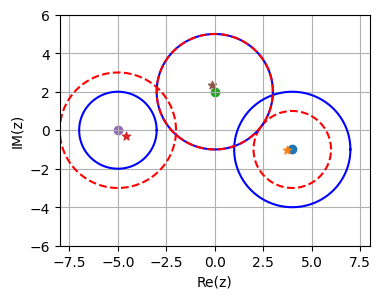

In [ ]:
def make_circle(c, r):
    theta = np.linspace(0, 2 * np.pi, 256)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.vstack((x, y)).T + c

c = np.array([[4, -1], [0, 2], [-5, 0]])


r = np.array([3, 3, 2])
s = np.array([2, 3, 3])

Gersh_c = np.array([make_circle(c[i], r[i]) for i in range(3)])
Gersh_d = np.array([make_circle(c[i], s[i]) for i in range(3)])

real_eig = np.array([[ 3.72 , -1.05 ],[-4.56 , -0.285],[-0.161,  2.34 ]])

plt.figure(figsize = (4,3))
for j in range(3):
  plt.plot(Gersh_c[j, :, 0], Gersh_c[j, :, 1], 'b-')
  plt.plot(Gersh_d[j, :, 0], Gersh_d[j, :, 1], 'r--')
  plt.scatter(c[j, 0], c[j, 1], marker='o')
  plt.scatter(real_eig[j, 0], real_eig[j, 1], marker='*')
plt.grid()
plt.xlabel('Re(z)')
plt.ylabel('IM(z)')
plt.xlim(-8, 8)
plt.ylim(-6, 6)
plt.show()

### 특이값 분해

특이값 분해 ***Singular Value Decomposition*** 은 많이 사용되는 도구로 특히 최소 제곱 문제에서 많이 사용된다. 이 분해는 정사각행렬이든 아니든 상관없이 모든 행렬에 적용할 수 있다. 행렬 $A$의 특이값이 $A^{T}A$ 의 고윳값의 음이 아닌 제곱근이라는 점에서부터 시작한다.



**행렬 스펙트럼 정리**

$A$ 가 $m \times n$ 일 때, $A^{T}A$ 는 $n \times n$ 대칭행렬이고 어떤 직교 행렬 $Q$에 의해 대각화가 가능하다. $A^{T}A = QDQ^{-1}$ 여기서 $QQ^{T} = Q^{T}Q = I, D$ 는 $n \times n$ 대각행렬이다.

이때, $A^{T}AQ = QD$ 이므로, $D$는 $A^{T}A$ 의 고윳값들로 이루어져 있으며 $Q$ 의 열은 고유벡터이다. $x$ 가 고유벡터라면, 상응하는 고윳값이 음수가 아님을 알 수 있다.

$$||Ax ||^{2} = x^{T}A^{T}Ax = x^{T}\lambda x = \lambda||x||^{2}$$

해당 고윳값들이 $\lambda_{i}$일 때, $A$ 의 특이값을 $\sigma_{j} = + \sqrt{\lambda_{j}}$ 로 정의한다.

다음으로 계산된 특이값들 중 굉장히 작은 값들은 $0$ 으로 간주할 수 있다. $0$ 이 아닌 특이값들의 개수가 $r$ 개라면 우리는 $r$ 을 수치적으로 계산한 $A$ 의 ***rank*** 라고 생각할 수 있다.

특이값 분해는 $A = UDV^{T}$ 와 같은 꼴로 표현된다. 이 때, $D$는 $d_{11} \geq d_{22} \geq \dots \geq 0$ 순으로 음이 아닌 성분으로 $A$ 의 특이값이다. 그리고 이전에 구한 고유벡터 $v_{1}, \cdots , v_{r}$ 들로 $u_{j}$ 를 얻을 수 있다.

$$u_{j} = Av_{j} / ||Av_{j}||$$

이 집합을 $\mathbb{R}^{m}$의 정규 직교 기저로 확장한다. 그리고 $V = Q$ 라 한다.

$$\sigma_{j}u_{j} = Av_{j}$$

정의된 특이값으로 조건수 ***condition number***를 표현할 수 있다.

$$\kappa(A) = \sqrt{\frac{\sigma_{max}}{\sigma_{min}}}$$

왜냐하면 $||A||^{2}_{2}= \rho(A^{T}A) = \sigma_{max}(A), \quad ||A^{-1}||^{2}_{2}= \rho(A^{-T}A^{-1}) = \sigma_{min}(A)$ 이기 때문이다.

# 8.3 누승법  Power method

누승법은 행렬의 고윳값을 계산하는 데 사용될 수 있다. 이 방법은 제대로 된 환경 하에서 주어진 행렬의 ***고윳값으로 수렴하는 수열을 생성하는 반복 과정***의 한 예이다.

먼저 $n \times n$ 행렬 $A$ 의 고윳값이 다음의 성질을 가진다고 가정한다.

$$|\lambda_{1}| > |\lambda_{2}| \geq |\lambda_{3}|  \geq \cdots \geq |\lambda_{n}|$$

그리고 각각의 고윳값은 0이 아닌 고유벡터 $u^{(i)}$를 가진다고 가정한다. 이 때, $n$ 개의 고유벡터로 이루어진 선형 독립 집합 $\{u^{(1)}, u^{(2)}, \cdots, u^{(n)}\}$ 은 $\mathbb{C}^{n}$ 의 기저이다.

---

이제 가장 큰 절댓값을 가진 단일한 고윳값(지배적인 고윳값 ***dominant eigenvalue***)과 그에 상응하는 고유벡터를 계산하려 한다. 임의의 시작 벡터 $x^{(0)} \in \mathbb{C}^{n}$ 을 선택하고 이를 고유벡터들의 선형결합으로 나타내며, $c_{1} \neq 0$ 라 가정한다.

이어서 일반성의 손실 없이***(W.L.O.G)*** 해당 상수들을 각 벡터에 흡수시킬 수 있다. 그리고 재귀적으로 $x^{(k)} = Ax^{(k-1)}$ 을 계산하여 벡터 수열을 생성할 수 있다.

\begin{eqnarray}
x^{(k)} &= &A^{k}x^{(0)} \\
&= &A^{k}u^{(1)} + A^{k}u^{(2)} + \cdots + A^{k}u^{(n)}\\
&= &\lambda^{k}_{1}u^{(1)} + \lambda^{k}_{2}u^{(2)} + \cdots + \lambda^{k}_{n}u^{(n)} \\
&= &\lambda_{1}[u^{(1)} + (\frac{\lambda_{2}}{\lambda_{1}})^{k}u^{(2)} + (\frac{\lambda_{3}}{\lambda_{1}})^{k}u^{(3)} + \cdots + (\frac{\lambda_{n}}{\lambda_{1}})^{k}u^{(n)}]
\end{eqnarray}

이 때, $\lambda_{1}$은 지배적인 고윳값이므로 $k \rightarrow \infty$ 일 때, $(\lambda_{j}/\lambda_{1})^{k} \rightarrow 0$ 을 얻는다. 이제 위 식을 단순화할 수 있다.

$$x^{(k)} = \lambda^{k}_{1}[u^{(1)} + \varepsilon^{(k)}]$$

여기서 $\varepsilon^{k} \rightarrow 0$ 이다. $\varphi$ 가 임의의 복소수 값을 가지는 $\mathbb{C}^{n}$ 의 선형 함수로 $\varphi(u^{(1)}) \neq 0$를 만족한다고 하자. 이 함수를 위 식에 적용할 수 있다.

$$\varphi(x^{(k)}) = \lambda^{k}_{1}[\varphi(u^{(1)}) + \varphi(\varepsilon^{(k)})]$$

그리고 선형 함수의 비율 $r_{k}$ 를 다음과 같이 정의한다.

$$r_{k} \equiv \frac{\varphi(x^{(k+1)}}{\varphi(x^{(k)}} = \lambda_{1}[\frac{\varphi(u^{(1)}) + \varphi(\varepsilon^{(k+1)})}{\varphi(u^{(1)}) + \varphi(\varepsilon^{(k)})}]\rightarrow \lambda_{1} \quad (k \rightarrow \infty)$$

따라서 수열 $\{r_{k}\}$ 의 수렴값을 통해 지배적인 고윳값 $\lambda_{1}$을 계산할 수 있다. 그리고 $x^{(k)}$의 계산이 거듭될수록 이에 대응되는 고유벡터로 수렴한다.

In [12]:
#Power method
def power_method(A, kmax, x, phi):
  x = x.reshape(-1, 1)
  size_n = len(A)
  power_df = []
  power_df.append([x, 0])
  for i in range(kmax):
    y = np.dot(A, x)
    r = phi(y)/phi(x)
    x = y
    power_df.append([x, r])

  power_df = pd.DataFrame(power_df)
  return power_df

test_x0 = np.array([0, 1])
test_A = np.array([[3, 1], [1, 3]])
def default_phi(temp_v):
  return temp_v[0]

power_method(test_A, 5, test_x0, default_phi)

<ipython-input-12-b0405ae16603>:9: RuntimeWarning: divide by zero encountered in divide
  r = phi(y)/phi(x)


,0,1
0,"[[0], [1]]",0
1,"[[1], [3]]",[inf]
2,"[[6], [10]]",[6.0]
3,"[[28], [36]]",[4.666666666666667]
4,"[[120], [136]]",[4.285714285714286]
5,"[[496], [528]]",[4.133333333333334]
